In [1]:
import pennylane as qml
import numpy as np

In [2]:
import torch
import torch.nn as nn

In [3]:
phi = np.pi/3
theta = np.pi/4
delta = np.pi/5

In [5]:
def PrepareTrueState():
    qml.U3(theta, phi, delta, wires = 0)

In [6]:
def Generator(weights):
    qml.U3(weights[0], weights[1], weights[2], wires = 0)

In [7]:
def DiscriminatorVF(nqubits, weights, reps = 1):
    par = 0
    for rep in range(reps):
        for q in range(nqubits):
            qml.RX(weights[par], wires = q)
            par += 1
            qml.RY(weights[par], wires = q)
            par += 1
            qml.RZ(weights[par], wires = q)
            par += 1
        for i in range(nqubits - 1):
            qml.CNOT(wires = [i, i + 1])
    for q in range(nqubits):
        qml.RX(weights[par], wires = q)
        par += 1
        qml.RY(weights[par], wires = q)
        par += 1
        qml.RZ(weights[par], wires = q)

In [8]:
def Discriminator(weights):
    DiscriminatorVF(2, weights, reps = 3)

In [9]:
state_0 = [[1], [0]]
M = state_0 * np.conj(state_0).T

In [10]:
dev = qml.device("default.qubit", wires = 2)

In [12]:
@qml.qnode(dev, interface = "torch", diff_method="backprop")
def true_discriminator(weights_dis):
    PrepareTrueState()
    Discriminator(weights_dis)
    return qml.expval(qml.Hermitian(M, wires = [0]))

In [13]:
@qml.qnode(dev, interface = "torch", diff_method = "backprop")
def generator_discriminator(weights_gen, weights_dis):
    Generator(weights_gen)
    Discriminator(weights_dis)
    return qml.expval(qml.Hermitian(M, wires = [0]))

In [14]:
weights_gen = torch.rand(3, requires_grad = True)
weights_dis = torch.rand(2*3*(3+1), requires_grad = True)

In [15]:
dis_losses = []
gen_losses = []
log_weights = []

In [18]:
optd = torch.optim.SGD([weights_dis], lr = 0.5)
optg = torch.optim.SGD([weights_gen], lr = 0.5)

In [20]:
def discriminator_loss(weights_gen, weights_dis):
    out_gen = generator_discriminator(weights_gen, weights_dis)
    out_true = true_discriminator(weights_dis)
    return -(torch.log(1 - out_gen) + torch.log(out_true))/2

In [21]:
def generator_loss(weights_gen, weights_dis):
    out_gen = generator_discriminator(weights_gen, weights_dis)
    return -torch.log(out_gen)

In [22]:
ncycles = 150
for i in range(ncycles):
    # Entrenar el discriminador
    optd.zero_grad()
    lossd = discriminator_loss(weights_gen.detach(), weights_dis)
    lossd.backward()
    optd.step()

    # Entrenar el generador
    optg.zero_grad()
    lossg = generator_loss(weights_gen, weights_dis.detach())
    lossg.backward()
    optg.step()

    # Guardar los datos
    lossd = float(lossd)
    lossg = float(lossg)
    dis_losses.append(lossd)
    gen_losses.append(lossg)
    log_weights.append(weights_gen.detach().clone().numpy())

    if np.mod(i + 1, 15) == 0:
        print("Epoch", i + 1, end = " ")
        print("| Discriminator loss:", round(lossd, 4), end = " ")
        print("| Generator loss:", round(lossg, 4))

/tmp/ipykernel_108907/2971439377.py:16: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  lossd = float(lossd)


Epoch 15 | Discriminator loss: 0.6665 | Generator loss: 0.7298
Epoch 30 | Discriminator loss: 0.6943 | Generator loss: 0.6885
Epoch 45 | Discriminator loss: 0.6939 | Generator loss: 0.6939
Epoch 60 | Discriminator loss: 0.6933 | Generator loss: 0.692
Epoch 75 | Discriminator loss: 0.6931 | Generator loss: 0.6936
Epoch 90 | Discriminator loss: 0.6931 | Generator loss: 0.693
Epoch 105 | Discriminator loss: 0.6931 | Generator loss: 0.6932
Epoch 120 | Discriminator loss: 0.6931 | Generator loss: 0.6931
Epoch 135 | Discriminator loss: 0.6931 | Generator loss: 0.6931
Epoch 150 | Discriminator loss: 0.6931 | Generator loss: 0.6932


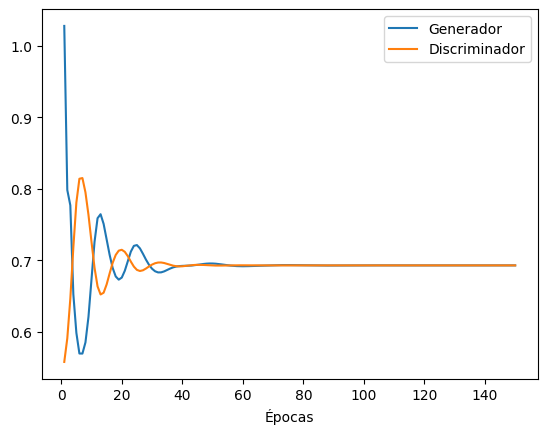

In [23]:
import matplotlib.pyplot as plt
epochs = np.array(range(len(gen_losses))) + 1
plt.plot(epochs, gen_losses, label = "Generador")
plt.plot(epochs, dis_losses, label = "Discriminador")
plt.xlabel("Épocas")
plt.legend()

In [24]:
@qml.qnode(dev, interface = "torch")
def generated_coordinates(weights_gen):
    Generator(weights_gen)
    return [qml.expval(qml.PauliX(0)), qml.expval(qml.PauliY(0)), qml.expval(qml.PauliZ(0))]

In [25]:
@qml.qnode(dev, interface = "torch")
def true_coordinates():
    PrepareTrueState()
    return [qml.expval(qml.PauliX(0)), qml.expval(qml.PauliY(0)), qml.expval(qml.PauliZ(0))]

In [26]:
print("Coordenadas Bloch")
print("Generadas: ", generated_coordinates(weights_gen))
print("Reales: ", true_coordinates())

Coordenadas Bloch
Generadas:  [tensor(0.3536, dtype=torch.float64, grad_fn=<DotBackward0>), tensor(0.6123, dtype=torch.float64, grad_fn=<DotBackward0>), tensor(0.7071, dtype=torch.float64, grad_fn=<DotBackward0>)]
Reales:  [tensor(0.3536, dtype=torch.float64), tensor(0.6124, dtype=torch.float64), tensor(0.7071, dtype=torch.float64)]


In [28]:
true_coords = true_coordinates()
def plot_coordinates(cycle):
    coords = generated_coordinates(log_weights[cycle - 1])
    plt.bar(["X", "Y", "Z"], true_coords, width = 1, color="royalblue", label = "Verdaderas")
    plt.bar(["X", "Y", "Z"], coords, width = 0.5, color="black", label = "Generadas")

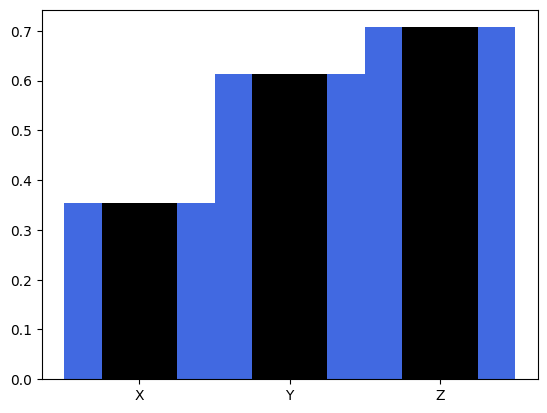

In [40]:
plot_coordinates(150)